In [1]:

import process_gens
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

# process_gen_mode="llama_gsm_sample"
# compare_metric='final_num_exact_match'

process_gen_mode="wmt_beam8_new"
# process_gen_mode="wmt_samples"
compare_metric="BLEU_4"
do_norm_analysis=True


processGens.init_with_mode(process_gen_mode)


root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics = processGens.get_params()

examples_df, completions_df=get_dfs(processGens, num_beams_list)


if(do_norm_analysis):
    for col in [compare_metric, 'output_logprob']:
        examples_df[col + '_norm'] = examples_df.groupby('instanceID')[col].transform(
            lambda x: (x - x.mean()) / x.std()
        )

dfs_by_model={}
for model_idx, model_name in enumerate(models):
    filtered_df = examples_df[examples_df["model"]==model_idx]
    dfs_by_model[model_name]=filtered_df


all_dfs_by_model=dfs_by_model
if(len(models)>1):
    all_dfs_by_model["all_models"]=examples_df

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode wmt_beam8_new
calculate_gen_summary_dict
get_metrics_dict


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

Index(['beam_num', 'task_name', 'model', 'example_idx', 'text',
       'completion_length', 'output_logprob', 'instanceID', 'isCompletion',
       'BLEU_1', 'BLEU_4'],
      dtype='object')
Num examples: 16000
Num completions: 1000


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [16] 
 	 models: ['meta_llama_Llama_3.1_8B_Instruct'] 
 	 custom_metrics['BLEU_1', 'BLEU_4']
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name full_wmt_1_samples_1000_evals 
 	 instance_metrics ['comet']
   beam_num  task_name  model  example_idx  \
0        16          0      0            0   
1        16          0      0            1   

                                                text  completion_length  \
0  He advised the parents of a boy whose penis ha...                174   
1  He advised the parents of a boy whose penis ha...                178   

   output_logprob instanceID isCompletion    BLEU_1    BLEU_4  BLEU_4_norm  \
0      -25.499125    id24245         True  0.736842  0.485714     1.006897   
1      -25.547735    id24245         None  0.710526  0.371429    -0.945872   

   output_logprob_norm  
0             1.558119  
1             1.488589  
num examples 16000
num_completions 1000
compare_

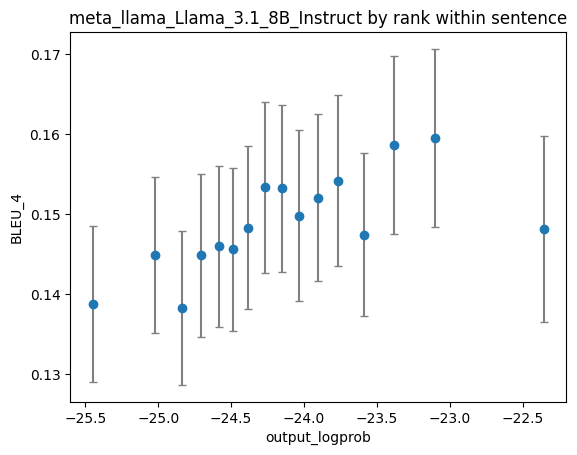

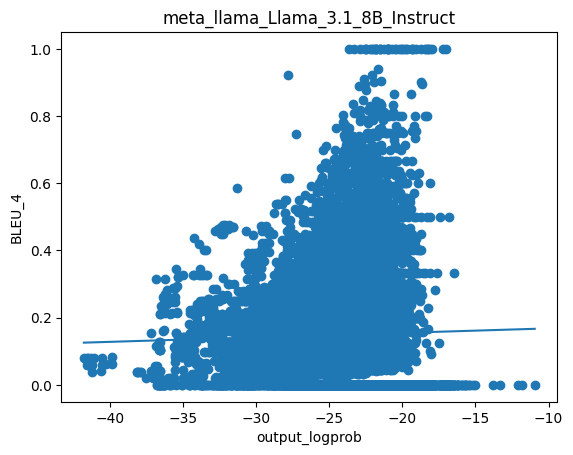

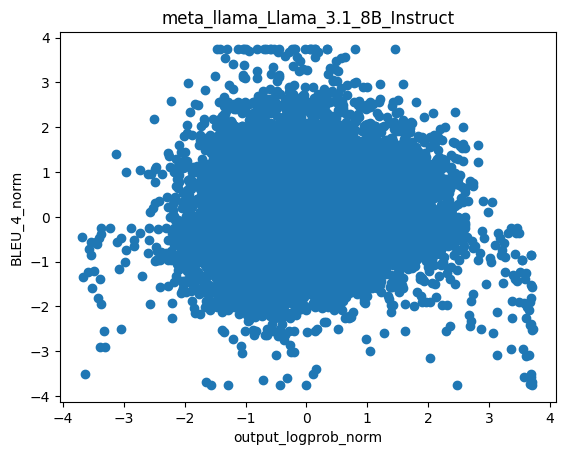

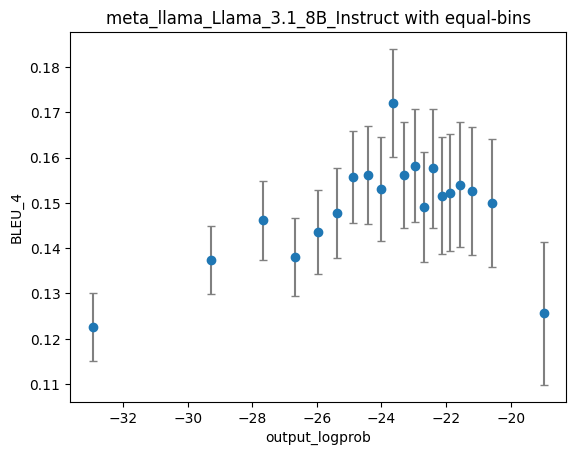

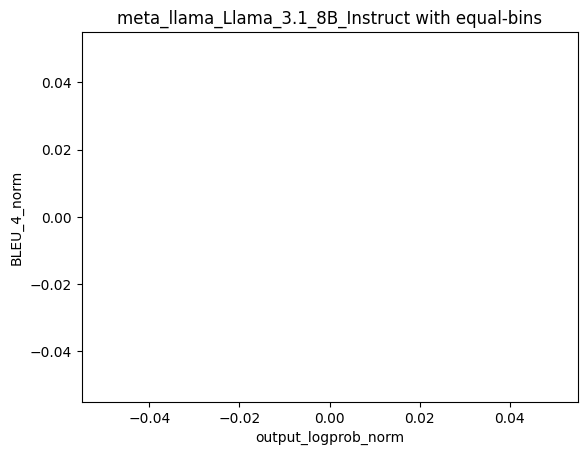

In [3]:

for model_name, filtered_dfs in dfs_by_model.items():
    # plot by rank within sentence
    plot_grouped(df=filtered_df, xlabel="output_logprob", ylabel=compare_metric, title=f"{model_name} by rank within sentence")

    # plot 
    plot_keys(df=examples_df, xlabel='output_logprob', ylabel=compare_metric, title=f"{model_name}")

    # just plot metric / probability (normalized) 
    plot_keys(df=filtered_df, xlabel='output_logprob_norm', ylabel=compare_metric+'_norm', title=model_name)

    # plot: group into equally-sized bins (ignores examples example_id)
    plot_grouped(df=filtered_dfs, xlabel="output_logprob", groupby="bins", ylabel=compare_metric, title=f"{model_name} with equal-bins")
    plot_grouped(df=filtered_df, xlabel='output_logprob_norm',  groupby="bins", ylabel=compare_metric+'_norm', title=f"{model_name} with equal-bins")
    